# Notebook for code development for vehicle stock module (vsm)

- 21 Oct 2025 - don't trust the vehicle stock data from starter kit or ministry. basing everything off PKM --> better utility as it can be used without houndin' the data
- 26 Oct 2025 - removed reliance on Kenya age data - don't trust it. Calibrating a "steady state" age distribution based on Zambian data for annual additions/new vehicles

In [52]:

# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# INPUT DATA

In [53]:
def return_input_data():
    """
    Returns input data for vehicle stock model.

    PKM data based on CCG Transport Starter Data Kit for Zambia plus estimates:
    - Road motorized: 17,857.36 million pkm (2018) - CAR 50%, BUS 37.5%, MOTO 12.5%
    - Rail: 40 million pkm (estimated from passenger counts)
    - Aviation: 67.97 million pkm (UN DESA 2018)
    - Walk: 17,000 million pkm (estimated: 2.6 km/day per person average)
    - Bike: 3,000 million pkm (estimated: 0.5 km/day per person average)

    Total passenger transport: ~37,965 million pkm (2018)
    Note: NMT represents 53% of total passenger PKM, reflecting Zambia's mobility reality
    """

    # Base year 2018 values
    base_total_road_pkm = 17857.36
    car_share = 0.50
    bus_share = 0.375
    moto_share = 0.125

    base_car = base_total_road_pkm * car_share      # 8,928.68
    base_bus = base_total_road_pkm * bus_share      # 6,696.51
    base_moto = base_total_road_pkm * moto_share    # 2,232.17
    base_train = 40.0     # Estimated from passenger counts (~390k passengers × 100km)
    base_plane = 67.97    # UN DESA
    base_walk = 17000.0   # Urban: 4,730M + Rural: 12,446M pkm (2.6 km/day avg)
    base_bike = 3000.0    # ~5% of trips, 5km avg distance (0.5 km/day avg)

    # Annual growth rates
    road_growth_rate = 1.029   # 2.9% annual
    rail_growth_rate = 1.015   # 1.5% annual (infrastructure constrained)
    aviation_growth_rate = 1.04  # 4% annual (faster growing)
    nmt_growth_rate = 1.005    # 0.5% annual (NMT slowly declining as motorization increases)

    # === PASSENGER TRANSPORT (passenger-kilometres, million pkm) ===
    pkm_by_mode = {}

    for i, year in enumerate(range(2018, 2031)):
        road_growth = road_growth_rate ** i
        rail_growth = rail_growth_rate ** i
        avia_growth = aviation_growth_rate ** i
        nmt_growth = nmt_growth_rate ** i

        # Pandemic dip in 2020
        if year == 2020:
            road_growth *= 0.98
            rail_growth *= 0.90
            avia_growth *= 0.50
            nmt_growth *= 1.03  # NMT increased during pandemic as people avoided crowded transport

        pkm_by_mode[year] = {
            'CAR': round(base_car * road_growth, 1),
            'BUS': round(base_bus * road_growth, 1),
            'MOTO': round(base_moto * road_growth, 1),
            'TRAIN': round(base_train * rail_growth, 1),
            'PLANE': round(base_plane * avia_growth, 1),
            'WALK': round(base_walk * nmt_growth, 1),
            'BIKE': round(base_bike * nmt_growth, 1)
        }

    # === FREIGHT TRANSPORT (tonne-kilometres, million tkm) ===
    base_road_freight = 5234.54
    base_rail_freight = 297
    base_air_freight = 81.56
    base_waterway_freight = 13.32

    tkm_by_mode = {}
    freight_growth = 1.025  # 2.5% annual growth

    for i, year in enumerate(range(2018, 2031)):
        growth = freight_growth ** i

        tkm_by_mode[year] = {
            'TRUCK': round(base_road_freight * growth, 1),
            'RAIL_FREIGHT': round(base_rail_freight * growth, 1),
            'AIR_FREIGHT': round(base_air_freight * growth, 1),
            'SHIP': round(base_waterway_freight * growth, 1)
        }

    # === OCCUPANCY / LOAD FACTORS ===
    occ_by_mode = {
        year: {
            'BUS': 15,
            'CAR': 2.5,
            'MOTO': 1.5,
            'TRAIN': 200,
            'PLANE': 150,
            'WALK': 1,      # Self-propelled, 1 person
            'BIKE': 1,      # Self-propelled, 1 person
            'TRUCK': 10,
            'RAIL_FREIGHT': 1000,
            'SHIP': 20000,
            'AIR_FREIGHT': 50
        }
        for year in range(2018, 2031)
    }

    # === AVERAGE ANNUAL KILOMETRAGE ===
    kilometrage_by_mode = {
        year: {
            'BUS': 30000,
            'CAR': 15000,
            'MOTO': 12000,
            'TRAIN': 150000,
            'PLANE': 2000000,
            'WALK': 950,       # 2.6 km/day × 365 days
            'BIKE': 1825,      # 5 km/day × 365 days
            'TRUCK': 100000,
            'RAIL_FREIGHT': 100000,
            'SHIP': 600000,
            'AIR_FREIGHT': 2000000
        }
        for year in range(2018, 2031)
    }

    return pkm_by_mode, tkm_by_mode, occ_by_mode, kilometrage_by_mode

In [54]:
# return age data - NEW STOCK (based on Zambian vehicle registration data (Malindi))
def return_age_data_new_stock():
    new_age_data = pd.read_csv('./../data/vehicle_stock/age_distribution_new_vehicles.csv')
    return new_age_data

In [55]:
# return age data - CUMULATIVE STOCK (based on calibrated long-run of Zambian vehicle registration data)
def return_age_data_cumulative_stock():
    age_data = pd.read_csv('./../data/vehicle_stock/base_year_age_distribution.csv')
    return age_data

In [56]:
# Scrappage curves
def generate_scrappage_curves(max_age=30):
    """
    Generate scrappage rates (age-specific) for various modes
    Returns DataFrame indexed by age, columns = modes, where values are
    scrappage rate from age → age+1.
    """
    # Kenya-calibrated parameters (Weibull survival)
    params = {
        'CAR':     {'eta': 14, 'beta': 3.0},
        'MOTO':    {'eta': 9,  'beta': 2.5},
        'BUS':     {'eta': 12, 'beta': 3.5},
        'TRUCK':   {'eta': 10, 'beta': 3.2},
        'TRAIN':   {'eta': 25, 'beta': 3.5},
        'PLANE':   {'eta': 25, 'beta': 3.0},
        'SHIP':    {'eta': 30, 'beta': 3.5}
    }

    ages = np.arange(0, max_age + 1)
    scrappage = pd.DataFrame(index=ages, columns=params.keys(), dtype=float)

    for mode, p in params.items():
        S = np.exp(- (ages / p['eta']) ** p['beta'])
        # Scrappage rate: proportion that exit between a and a+1
        # i.e. 1 - S(a+1)/S(a)
        # For final age, assume full scrappage
        rates = 1 - (S[1:] / S[:-1])
        # Append rate = 1 for last age (everything scrapped)
        rates = np.append(rates, 1.0)
        scrappage[mode] = rates

    return scrappage

# BASE YEAR STOCK

In [57]:
def calculate_base_year_stock(base_year=2018):
    """
    Calculate the actual number of vehicles by mode and age in the base year.

    Uses:
    - PKM data for base year
    - Occupancy rates
    - Kilometrage (annual km per vehicle)
    - Base year age distribution (proportions)

    Returns:
    Dictionary of form {year: {mode: {age: vehicle_count}}}
    """
    # Get input data
    pkm_by_mode, tkm_by_mode, occ_by_mode, kilometrage_by_mode = return_input_data()

    # Get base year age distribution (proportions)
    age_distribution = return_age_data_cumulative_stock()

    # Initialize output dictionary
    base_year_stock = {base_year: {}}

    # Modes we're modelling
    modes = ['CAR', 'BUS', 'MOTO']

    for mode in modes:
        # Skip if mode not in age distribution
        if mode not in age_distribution.columns:
            continue

        # Calculate total number of vehicles needed for this mode
        # vehicles = PKM / (occupancy * annual_km_per_vehicle)
        pkm = pkm_by_mode[base_year][mode]  # million pkm
        occupancy = occ_by_mode[base_year][mode]  # passengers per vehicle
        annual_km = kilometrage_by_mode[base_year][mode]  # km per vehicle per year

        # Total vehicles needed
        total_vehicles = (pkm * 1e6) / (occupancy * annual_km)

        # Get age distribution for this mode (proportions)
        age_props = age_distribution[mode].values

        # Distribute total vehicles across ages according to proportions
        vehicles_by_age = {}
        for age in range(len(age_props)):
            vehicles_by_age[age] = total_vehicles * age_props[age]

        # Store in output dictionary
        base_year_stock[base_year][mode] = vehicles_by_age

    return base_year_stock

In [58]:
base_year_stock = calculate_base_year_stock()

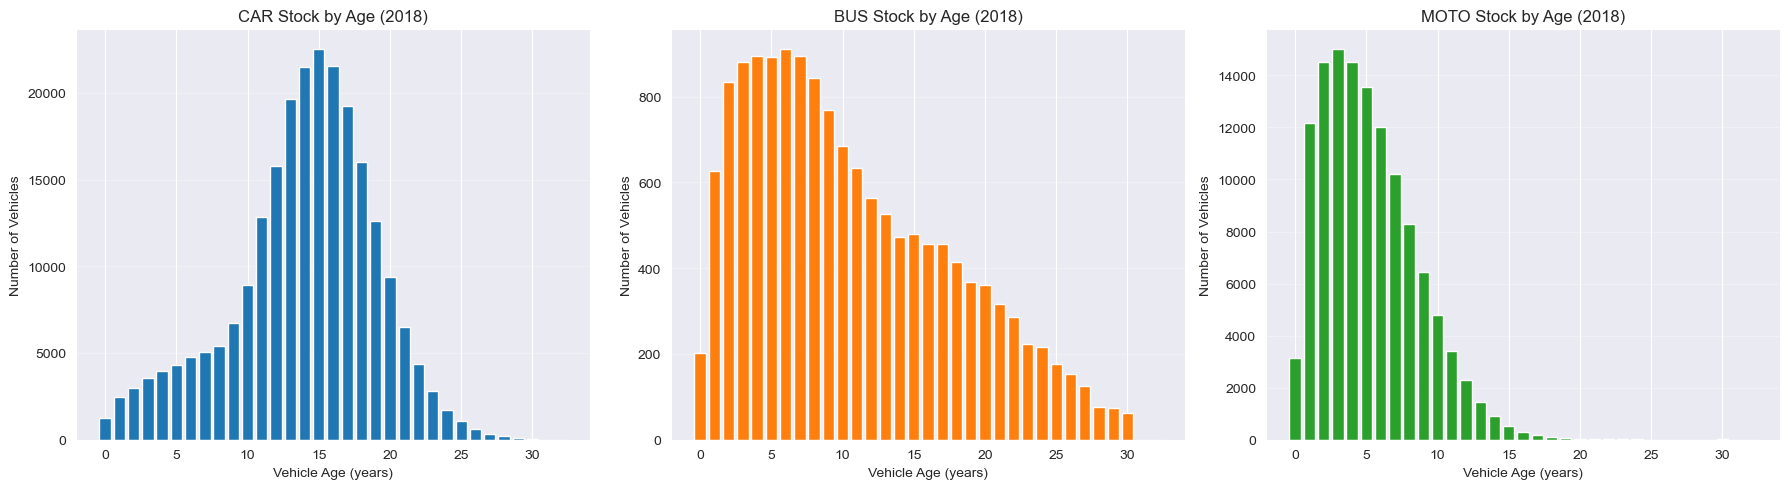

In [59]:
# Validation plot

validation_plot=1

if validation_plot>0:
    # Calculate base year stock
    base_year_stock = calculate_base_year_stock(base_year=2018)

    # Extract data for plotting
    modes = ['CAR', 'BUS', 'MOTO']
    ages = list(range(33))  # 0 to 32

    # Set up the plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, mode in enumerate(modes):
        ax = axes[idx]

        # Get vehicle counts by age for this mode
        vehicle_counts = [base_year_stock[2018][mode].get(age, 0) for age in ages]

        # Create bar chart
        ax.bar(ages, vehicle_counts, color=sns.color_palette()[idx])
        ax.set_xlabel('Vehicle Age (years)')
        ax.set_ylabel('Number of Vehicles')
        ax.set_title(f'{mode} Stock by Age (2018)')
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# DESIRED STOCK BY YEAR

In [60]:
def calculate_desired_stock(start_year=2018, end_year=2030, modes=['CAR', 'BUS', 'MOTO']):
    """
    Calculate the desired total vehicle stock by mode and year.

    Uses:
    - PKM data for each year
    - Occupancy rates
    - Kilometrage (annual km per vehicle)

    Returns:
    Dictionary of form {year: {mode: total_vehicles}}
    """
    # Get input data
    pkm_by_mode, tkm_by_mode, occ_by_mode, kilometrage_by_mode = return_input_data()

    # Initialize output dictionary
    desired_stock = {}

    for year in range(start_year, end_year + 1):
        desired_stock[year] = {}

        for mode in modes:
            # Calculate total number of vehicles needed for this mode
            # vehicles = PKM / (occupancy * annual_km_per_vehicle)
            pkm = pkm_by_mode[year][mode]  # million pkm
            occupancy = occ_by_mode[year][mode]  # passengers per vehicle
            annual_km = kilometrage_by_mode[year][mode]  # km per vehicle per year

            # Total vehicles needed
            total_vehicles = (pkm * 1e6) / (occupancy * annual_km)

            desired_stock[year][mode] = total_vehicles

    return desired_stock

In [61]:
# Validation check
desired = calculate_desired_stock()
base = calculate_base_year_stock()

for mode in ['CAR', 'BUS', 'MOTO']:
    desired_total = desired[2018][mode]
    base_total = sum(base[2018][mode].values())
    print(f"{mode}: Desired={desired_total:.0f}, Base={base_total:.0f}, Match={np.isclose(desired_total, base_total)}")

CAR: Desired=238099, Base=238099, Match=True
BUS: Desired=14881, Base=14881, Match=True
MOTO: Desired=124011, Base=124011, Match=True


# CALCULATE ANNUAL STOCK

In [62]:
def calculate_annual_stock_additions_scrap(start_year=2018, end_year=2030, max_age=32):
    """
    Calculate annual vehicle stock, additions, and scrappage for each year.

    Process:
    - Year 2018: Initialize with base_year_stock only (no scrap/additions calculated)
    - Year Y (Y>2018):
      1. Age stock[Y-1] by one year
      2. Calculate scrap[Y-1] from aged stock (before additions)
      3. Calculate additions[Y] = desired[Y] - stock[Y-1] + scrap[Y-1]
      4. Add additions[Y] to create stock[Y]

    Returns three dictionaries:
    - annual_stock: dict[year][mode][age] -> number of vehicles
    - annual_additions: dict[year][mode][age] -> vehicles added that year
    - annual_scrap: dict[year][mode][age] -> vehicles scrapped that year
    """

    # Get input data
    desired_stock = calculate_desired_stock(start_year, end_year)
    base_year_stock = calculate_base_year_stock(start_year)
    scrappage_rates = generate_scrappage_curves(max_age)
    new_age_data = return_age_data_new_stock()

    # Initialize output dictionaries
    annual_stock = {}
    annual_additions = {}
    annual_scrap = {}

    # Modes we're modeling
    modes = ['CAR', 'BUS', 'MOTO']

    # Helper function to get inflow age distribution for a given year and mode
    def get_inflow_distribution(mode, year):
        if year <= 2023:
            column_name = f'{mode}_{year}'
        else:
            column_name = f'{mode}_2023'  # Use 2023 distribution for future years

        if column_name not in new_age_data.columns:
            print(f"Warning: {column_name} not found, using average distribution")
            mode_columns = [col for col in new_age_data.columns if col.startswith(f'{mode}_')]
            distribution = new_age_data[mode_columns].mean(axis=1).values
        else:
            distribution = new_age_data[column_name].values

        distribution = distribution / distribution.sum()  # Normalize to sum to 1
        return distribution

    # Initialize base year (2018) - stock only, no scrap or additions
    annual_stock[start_year] = base_year_stock[start_year]

    # Loop through years starting from 2019
    for year in range(start_year + 1, end_year + 1):

        prev_year = year - 1

        # Initialize dictionaries for previous year's scrap and current year's additions/stock
        if prev_year not in annual_scrap:
            annual_scrap[prev_year] = {}
        if year not in annual_additions:
            annual_additions[year] = {}
        if year not in annual_stock:
            annual_stock[year] = {}

        for mode in modes:

            # === STEP 1: Age the previous year's stock by 1 year ===
            aged_stock = {}
            for age in range(max_age + 1):
                if age == 0:
                    aged_stock[0] = 0  # No vehicles age into age 0
                else:
                    aged_stock[age] = annual_stock[prev_year][mode].get(age - 1, 0)

            # Vehicles at max_age stay at max_age (can't age further)
            aged_stock[max_age] += annual_stock[prev_year][mode].get(max_age, 0)

            # === STEP 2: Calculate scrappage from aged stock ===
            annual_scrap[prev_year][mode] = {}

            for age in range(max_age + 1):
                vehicles_at_age = aged_stock[age]
                scrap_rate = scrappage_rates[mode].iloc[age]
                scrapped = vehicles_at_age * scrap_rate
                annual_scrap[prev_year][mode][age] = scrapped

            # === STEP 3: Calculate additions needed using governing equation ===
            total_stock_prev = sum(annual_stock[prev_year][mode].values())
            total_scrap_prev = sum(annual_scrap[prev_year][mode].values())
            total_desired = desired_stock[year][mode]

            additions_needed = total_desired - total_stock_prev + total_scrap_prev
            additions_needed = max(0, additions_needed)  # No negative additions

            # Distribute additions across ages using Zambia age distribution
            inflow_dist = get_inflow_distribution(mode, year)
            annual_additions[year][mode] = {}

            for age in range(len(inflow_dist)):
                annual_additions[year][mode][age] = additions_needed * inflow_dist[age]

            for age in range(len(inflow_dist), max_age + 1):
                annual_additions[year][mode][age] = 0

            # === STEP 4: Calculate current year's stock ===
            # Stock = aged stock - scrap + additions
            annual_stock[year][mode] = {}

            for age in range(max_age + 1):
                aged_vehicles = aged_stock.get(age, 0)
                scrapped_vehicles = annual_scrap[prev_year][mode].get(age, 0)
                added_vehicles = annual_additions[year][mode].get(age, 0)

                annual_stock[year][mode][age] = aged_vehicles - scrapped_vehicles + added_vehicles

    return annual_stock, annual_additions, annual_scrap

In [63]:
# Run the model
annual_stock, annual_additions, annual_scrap = calculate_annual_stock_additions_scrap(
    start_year=2018,
    end_year=2030,
    max_age=32
)

# Let's examine CAR in detail for a few years
print("=" * 80)
print("CAR ANALYSIS")
print("=" * 80)

# Check 2018 (base year)
print("\n2018 (Base Year):")
print(f"  Total stock: {sum(annual_stock[2018]['CAR'].values()):,.0f} vehicles")
print("  (No scrap/additions calculated for base year)")

# Check stock by age bins for 2018 - use .get() to handle missing ages
ages_0_5 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(0, 6)])
ages_6_10 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(6, 11)])
ages_11_15 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(11, 16)])
ages_16_20 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(16, 21)])
ages_21plus = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(21, 33)])

print(f"\n  Stock by age group:")
print(f"    0-5 years: {ages_0_5:,.0f} ({ages_0_5/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    6-10 years: {ages_6_10:,.0f} ({ages_6_10/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    11-15 years: {ages_11_15:,.0f} ({ages_11_15/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    16-20 years: {ages_16_20:,.0f} ({ages_16_20/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    21+ years: {ages_21plus:,.0f} ({ages_21plus/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")

# Check a few subsequent years
for year in [2019, 2020, 2025, 2030]:
    print(f"\n{year}:")
    print(f"  Total stock: {sum(annual_stock[year]['CAR'].values()):,.0f} vehicles")

    # Scrap is calculated for year-1
    if year - 1 in annual_scrap and 'CAR' in annual_scrap[year - 1]:
        print(f"  Total scrap (from {year-1}): {sum(annual_scrap[year-1]['CAR'].values()):,.0f} vehicles")

    print(f"  Total additions: {sum(annual_additions[year]['CAR'].values()):,.0f} vehicles")
    print(f"  Desired stock: {calculate_desired_stock(2018, 2030)[year]['CAR']:,.0f} vehicles")

    # Show balance using governing equation
    stock_prev = sum(annual_stock[year-1]['CAR'].values())
    scrap_prev = sum(annual_scrap[year-1]['CAR'].values()) if year-1 in annual_scrap else 0
    additions_curr = sum(annual_additions[year]['CAR'].values())
    stock_curr = sum(annual_stock[year]['CAR'].values())
    desired_curr = calculate_desired_stock(2018, 2030)[year]['CAR']

    print(f"  Governing equation: {desired_curr:,.0f} - {stock_prev:,.0f} + {scrap_prev:,.0f} = {additions_curr:,.0f}")
    print(f"  Stock calculation: {stock_prev:,.0f} - {scrap_prev:,.0f} + {additions_curr:,.0f} = {stock_curr:,.0f}")
    print(f"  Gap to desired: {desired_curr - stock_curr:,.0f} vehicles")

# Summary table across all years for all modes
print("\n" + "=" * 80)
print("SUMMARY: Total Fleet by Mode and Year")
print("=" * 80)
print(f"{'Year':<6} {'CAR':>12} {'BUS':>12} {'MOTO':>12} {'Total':>12}")
print("-" * 80)

for year in range(2018, 2031):
    car_total = sum(annual_stock[year]['CAR'].values())
    bus_total = sum(annual_stock[year]['BUS'].values())
    moto_total = sum(annual_stock[year]['MOTO'].values())
    total = car_total + bus_total + moto_total
    print(f"{year:<6} {car_total:>12,.0f} {bus_total:>12,.0f} {moto_total:>12,.0f} {total:>12,.0f}")

# Check if model is working correctly - compare to desired stock
print("\n" + "=" * 80)
print("MODEL VALIDATION: Stock vs Desired")
print("=" * 80)
print(f"{'Year':<6} {'Mode':<6} {'Actual Stock':>15} {'Desired Stock':>15} {'Difference':>15} {'% Diff':>10}")
print("-" * 80)

desired = calculate_desired_stock(2018, 2030)
for year in [2018, 2020, 2025, 2030]:
    for mode in ['CAR', 'BUS', 'MOTO']:
        actual = sum(annual_stock[year][mode].values())
        desired_val = desired[year][mode]
        diff = actual - desired_val
        pct_diff = (diff / desired_val) * 100 if desired_val > 0 else 0
        print(f"{year:<6} {mode:<6} {actual:>15,.0f} {desired_val:>15,.0f} {diff:>15,.0f} {pct_diff:>9.2f}%")

CAR ANALYSIS

2018 (Base Year):
  Total stock: 238,099 vehicles
  (No scrap/additions calculated for base year)

  Stock by age group:
    0-5 years: 18,511 (7.8%)
    6-10 years: 30,814 (12.9%)
    11-15 years: 92,242 (38.7%)
    16-20 years: 78,738 (33.1%)
    21+ years: 17,793 (7.5%)

2019:
  Total stock: 252,147 vehicles
  Total scrap (from 2018): 57,522 vehicles
  Total additions: 71,570 vehicles
  Desired stock: 252,147 vehicles
  Governing equation: 252,147 - 238,099 + 57,522 = 71,570
  Stock calculation: 238,099 - 57,522 + 71,570 = 252,147
  Gap to desired: -0 vehicles

2020:
  Total stock: 261,683 vehicles
  Total scrap (from 2019): 59,298 vehicles
  Total additions: 68,834 vehicles
  Desired stock: 261,683 vehicles
  Governing equation: 261,683 - 252,147 + 59,298 = 68,834
  Stock calculation: 252,147 - 59,298 + 68,834 = 261,683
  Gap to desired: 0 vehicles

2025:
  Total stock: 355,653 vehicles
  Total scrap (from 2024): 84,209 vehicles
  Total additions: 104,023 vehicles
  D

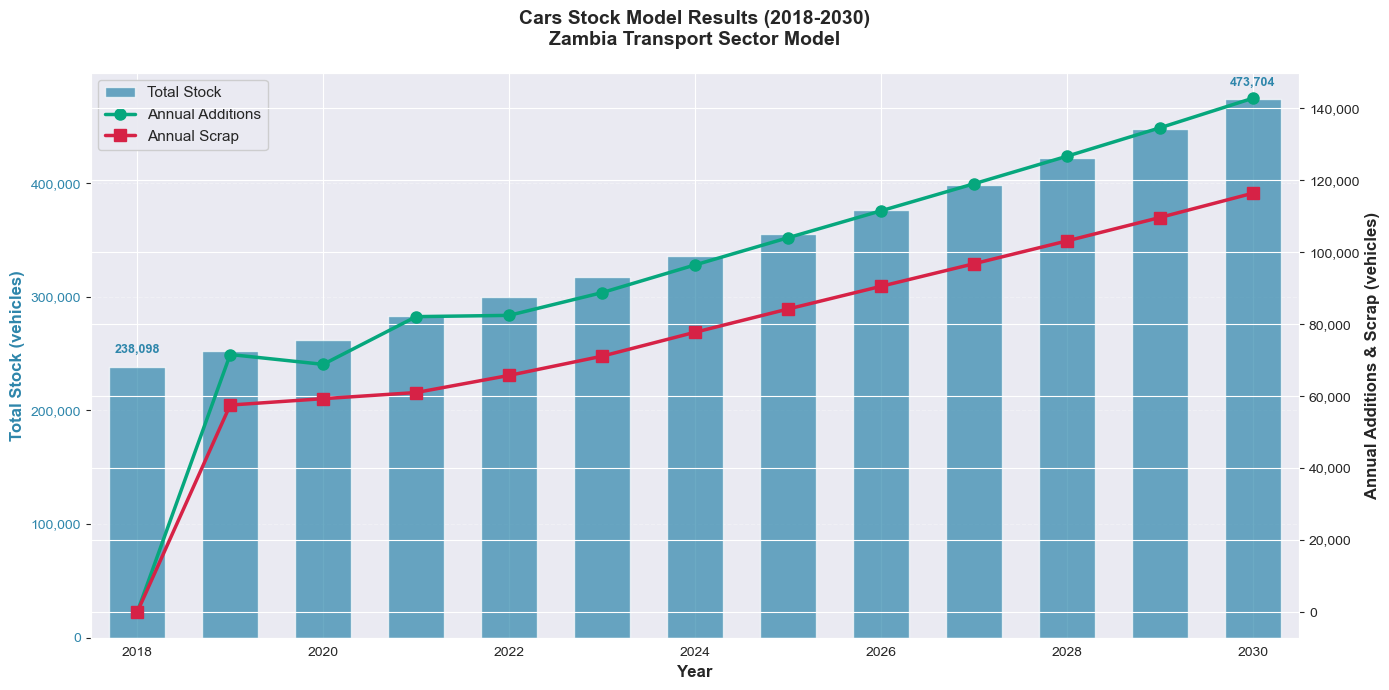


SUMMARY STATISTICS: Cars
Base Year (2018) Stock:        238,098 vehicles
Final Year (2030) Stock:        473,704 vehicles
Absolute Growth:                      235,605 vehicles
Percentage Growth:                       99.0%

Total Additions (2019-2030):  1,228,725 vehicles
Total Scrap (2018-2029):      993,120 vehicles
Net Change:                           235,605 vehicles

Average Annual Additions:             102,393 vehicles/year
Average Annual Scrap:                  82,760 vehicles/year
Average Scrappage Rate:                   1.7% of fleet/year


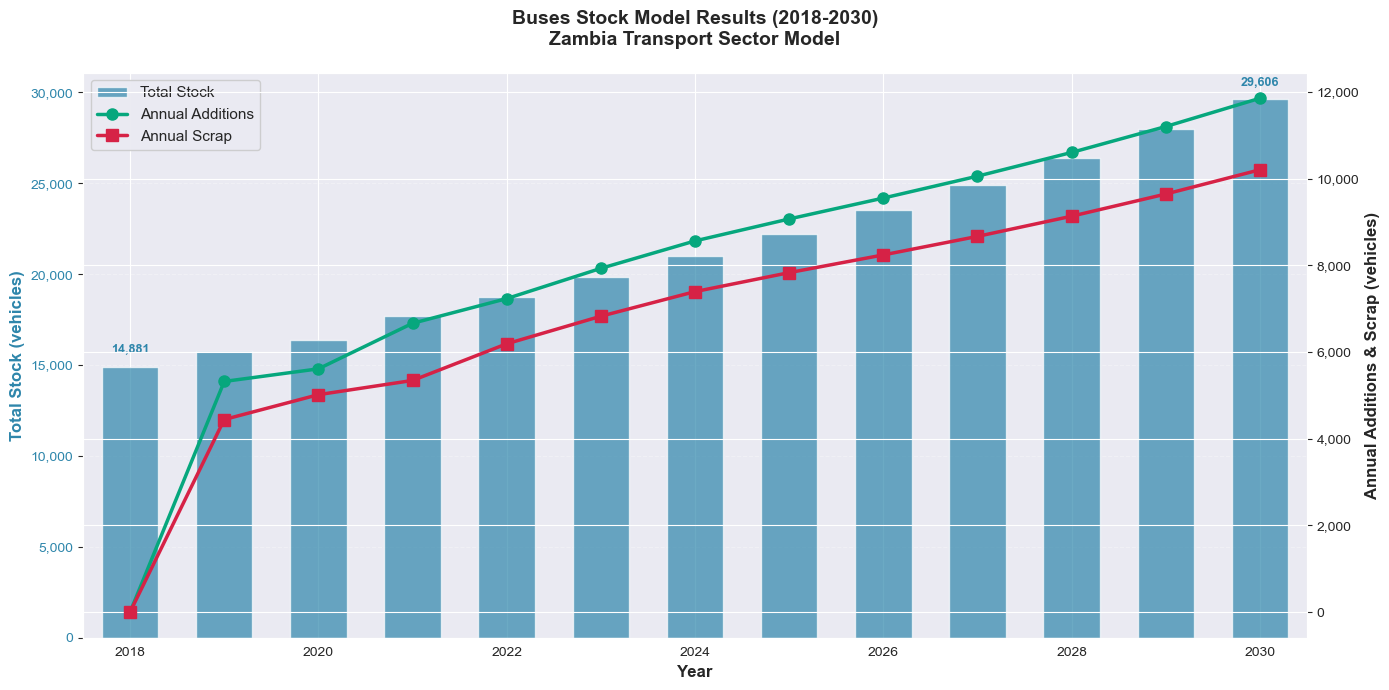


SUMMARY STATISTICS: Buses
Base Year (2018) Stock:         14,881 vehicles
Final Year (2030) Stock:         29,606 vehicles
Absolute Growth:                       14,725 vehicles
Percentage Growth:                       99.0%

Total Additions (2019-2030):    103,636 vehicles
Total Scrap (2018-2029):       88,911 vehicles
Net Change:                            14,725 vehicles

Average Annual Additions:               8,636 vehicles/year
Average Annual Scrap:                   7,409 vehicles/year
Average Scrappage Rate:                   2.5% of fleet/year


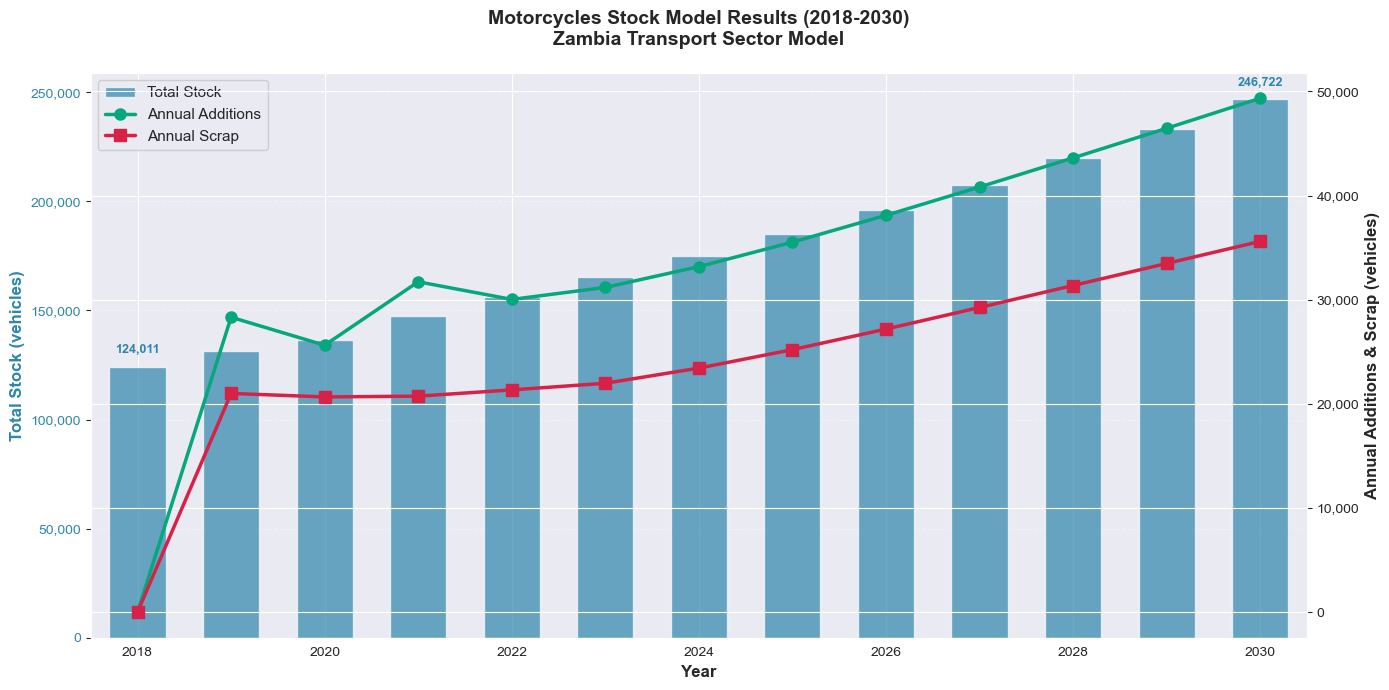


SUMMARY STATISTICS: Motorcycles
Base Year (2018) Stock:        124,011 vehicles
Final Year (2030) Stock:        246,722 vehicles
Absolute Growth:                      122,711 vehicles
Percentage Growth:                       99.0%

Total Additions (2019-2030):    433,892 vehicles
Total Scrap (2018-2029):      311,181 vehicles
Net Change:                           122,711 vehicles

Average Annual Additions:              36,157 vehicles/year
Average Annual Scrap:                  25,931 vehicles/year
Average Scrappage Rate:                   1.0% of fleet/year


In [64]:
def plot_stock_model_results(vehicle_type='CAR', start_year=2018, end_year=2030):
    """
    Plot the annual stock, additions, and scrap for a given vehicle type.

    Parameters:
    - vehicle_type: str, one of 'CAR', 'BUS', 'MOTO'
    - start_year: int, starting year (default 2018)
    - end_year: int, ending year (default 2030)
    """

    # Get the model results
    annual_stock, annual_additions, annual_scrap = calculate_annual_stock_additions_scrap(
        start_year=start_year,
        end_year=end_year
    )

    # Extract totals for each year
    years = list(range(start_year, end_year + 1))
    stock_totals = []
    additions_totals = []
    scrap_totals = []

    for year in years:
        stock_totals.append(sum(annual_stock[year][vehicle_type].values()))

        # Additions start from 2019
        if year > start_year:
            additions_totals.append(sum(annual_additions[year][vehicle_type].values()))
        else:
            additions_totals.append(0)  # No additions in base year

        # Scrap calculated from year-1's stock, so first scrap is 2018
        if year > start_year:
            scrap_totals.append(sum(annual_scrap[year-1][vehicle_type].values()))
        else:
            scrap_totals.append(0)  # No scrap calculated for base year

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot stock as bars
    bars = ax.bar(years, stock_totals, color='#2E86AB', alpha=0.7, label='Total Stock', width=0.6)

    # Plot additions and scrap as lines
    ax2 = ax.twinx()
    line1 = ax2.plot(years, additions_totals, color='#06A77D', marker='o', linewidth=2.5,
                     markersize=8, label='Annual Additions')
    line2 = ax2.plot(years, scrap_totals, color='#D62246', marker='s', linewidth=2.5,
                     markersize=8, label='Annual Scrap')

    # Labels and title
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Stock (vehicles)', fontsize=12, fontweight='bold', color='#2E86AB')
    ax2.set_ylabel('Annual Additions & Scrap (vehicles)', fontsize=12, fontweight='bold')

    vehicle_names = {'CAR': 'Cars', 'BUS': 'Buses', 'MOTO': 'Motorcycles'}
    ax.set_title(f'{vehicle_names[vehicle_type]} Stock Model Results (2018-2030)\n'
                 f'Zambia Transport Sector Model',
                 fontsize=14, fontweight='bold', pad=20)

    # Formatting
    ax.tick_params(axis='y', labelcolor='#2E86AB')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xlim(start_year - 0.5, end_year + 0.5)

    # Format y-axis with thousand separators
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    # Combine legends - FIX HERE
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2,
              loc='upper left', fontsize=11, framealpha=0.95)

    # Add annotations for key years
    for i, year in enumerate([start_year, end_year]):
        idx = years.index(year)
        ax.annotate(f'{int(stock_totals[idx]):,}',
                   xy=(year, stock_totals[idx]),
                   xytext=(0, 10),
                   textcoords='offset points',
                   ha='center',
                   fontsize=9,
                   fontweight='bold',
                   color='#2E86AB')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "=" * 70)
    print(f"SUMMARY STATISTICS: {vehicle_names[vehicle_type]}")
    print("=" * 70)
    print(f"Base Year ({start_year}) Stock:     {int(stock_totals[0]):>10,} vehicles")
    print(f"Final Year ({end_year}) Stock:     {int(stock_totals[-1]):>10,} vehicles")
    print(f"Absolute Growth:                   {int(stock_totals[-1] - stock_totals[0]):>10,} vehicles")
    print(f"Percentage Growth:                 {((stock_totals[-1]/stock_totals[0])-1)*100:>10.1f}%")
    print(f"\nTotal Additions (2019-{end_year}): {int(sum(additions_totals)):>10,} vehicles")
    print(f"Total Scrap (2018-{end_year-1}):   {int(sum(scrap_totals)):>10,} vehicles")
    print(f"Net Change:                        {int(sum(additions_totals) - sum(scrap_totals)):>10,} vehicles")
    print(f"\nAverage Annual Additions:          {int(sum(additions_totals)/(end_year-start_year)):>10,} vehicles/year")
    print(f"Average Annual Scrap:              {int(sum(scrap_totals)/(end_year-start_year)):>10,} vehicles/year")
    print(f"Average Scrappage Rate:            {(sum(scrap_totals)/sum(stock_totals))*100/(end_year-start_year+1):>10.1f}% of fleet/year")
    print("=" * 70)

# Plot all three vehicle types
for vehicle in ['CAR', 'BUS', 'MOTO']:
    plot_stock_model_results(vehicle)

# TECHNOLOGY CHOICE

Next, we will take each annual_additions value and run it through a technology choice model. Stay tuned...